# Neural machine translation with attention

Данильченко Вадим

на основе ноутбука для машинного перевода с одного языка на другой сделаю классификацию тематик обращений клиентов к чат-боту.

class	intent
- 0	узнать возраст бота
- 1	узнать какую музыку слушает бот
- 2	узнать любит ли бот путешествовать
- 3	узнать где работает бот
- 4	узнать информацию про семью бота
- 5	узнать как относится бот к спорту
- 6	узнать где учится бот
- 7	узнать что читает бот
- 8	узнать есть ли у бота животные
- 9	узнать есть ли у бота машина
- 10	узнать как выглядит бот
- 11	узнать как зовут бота
- 12	узнать какие парни/девушки нравятся
- 13	узнать какой пол у бота
- 14	узнать кто такой бот
- 15	узнать кулинарные пристрастия бота
- 16	узнать о чем мечтает бот
- 17	поблагодарить бота
- 18	поприветствовать бота
- 19	попрощаться с ботом
- 20	разослать информацию студентам на email
- 21	узнать как дела
- 22	узнать метеопрогноз на сегодня
- 23	узнать об увлечениях
- 24	узнать откуда бот
- 25	узнать расписание занятий
- 26	узнать чем занимается бот
- 27	услышать анекдот
- 28	узнать о преподавателе
- 29	сделать уведомление студентам канала
- 30	узнать что умеет бот

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## prepare the dataset

here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [2]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Zа-яА-Я?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [3]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(lang):
#     lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [preprocess_sentence(w) for w in lang]

    return word_pairs

In [4]:
create_dataset(['привет','как дела?'])

['<start> привет <end>', '<start> как дела ? <end>']

In [5]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [6]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [7]:
def load_dataset(inp_lang, targ_lang):
    # creating cleaned input, output pairs
#     targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

загрузим пары фраза(inp_lang)-тематика(targ_lang)

In [50]:
inp_lang = []
with open('F:/ОБУЧЕНИЕ/CHAT-BOTs/тексты/dialogues/_phrases3.txt', encoding='utf-8') as f:
    inp_lang.append(f.readlines())
inp_lang = inp_lang[0]
print('размер:', len(inp_lang))
inp_lang[700:725]

размер: 747


['напиши что нибудь смешное\n',
 'пошути как нибудь\n',
 'расскажи анекдот\n',
 'расскажи прикол\n',
 'смешное что-нибудь напиши\n',
 'услышать анекдот\n',
 'шутить умеешь\n',
 'шутки знаешь\n',
 'информация о преподавателе\n',
 'кто наш лектор\n',
 'кто такой Данильченко\n',
 'получить информацию о преподавателе\n',
 'препод инфо\n',
 'преподаватель\n',
 'преподаватель инфо\n',
 'преподаватель информация\n',
 'узнать о лекторе\n',
 'узнать о преподавателе\n',
 'выслать в слак всем\n',
 'инфо студентам в слак послать\n',
 'отправить в группу\n',
 'отправить в слак\n',
 'отправить инфо в канал\n',
 'отправить с slack\n',
 'послать в slack\n']

In [52]:
targ_lang = []
with open('F:/ОБУЧЕНИЕ/CHAT-BOTs/тексты/dialogues/_intents3.txt', encoding='utf-8') as f:
    targ_lang.append(f.readlines())
targ_lang = targ_lang[0]
print('размер:', len(targ_lang))
targ_lang[700:725]

размер: 747


['услышать анекдот\n',
 'услышать анекдот\n',
 'услышать анекдот\n',
 'услышать анекдот\n',
 'услышать анекдот\n',
 'услышать анекдот\n',
 'услышать анекдот\n',
 'услышать анекдот\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'узнать о преподавателе\n',
 'сделать уведомление студентам канала\n',
 'сделать уведомление студентам канала\n',
 'сделать уведомление студентам канала\n',
 'сделать уведомление студентам канала\n',
 'сделать уведомление студентам канала\n',
 'сделать уведомление студентам канала\n',
 'сделать уведомление студентам канала\n']

In [53]:
%%time
# Try experimenting with the size of that dataset
# num_examples = 30000
# import joblib
# inp_lang = joblib.load('F:/ОБУЧЕНИЕ/CHAT-BOTs/тексты/dialogues/_intents.txt')
# targ_lang = joblib.load('F:/ОБУЧЕНИЕ/CHAT-BOTs/тексты/dialogues/answers_short.pkl')

inp_lang = create_dataset(inp_lang)
targ_lang = create_dataset(targ_lang)

input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(inp_lang, targ_lang)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

Wall time: 73.8 ms


In [54]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

597 597 150 150


In [55]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [56]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> а
39 ----> какую
45 ----> музыку
3 ----> ты
63 ----> слушаешь
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
3 ----> узнать
37 ----> какую
38 ----> музыку
39 ----> слушает
4 ----> бот
2 ----> <end>


### Create a tf.data dataset

In [57]:
%%time
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset = dataset.batch(BATCH_SIZE)

Wall time: 1.97 ms


In [58]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 10]), TensorShape([64, 8]))

## Write the encoder and decoder model

Implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input words is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence. The below picture and formulas are an example of attention mechanism from [Luong's paper](https://arxiv.org/abs/1508.04025v5). 

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*.

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

This tutorial uses [Bahdanau attention](https://arxiv.org/pdf/1409.0473.pdf) for the encoder. Let's decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, hidden_size)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU

The shapes of all the vectors at each step have been specified in the comments in the code:

In [59]:
# создадим класс, возвращающий выходные данные и состояние GRU-слоя
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [62]:
# инициализируем модель
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 10, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [63]:
# реализуем механизм attention
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [64]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 10, 1)


In [65]:
# создадим из GRU и Dense слоев декодер, принимающий на вход выходные состояния энкодера
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [66]:
# инициализируем декодер
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)), 
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 69)


## Define the optimizer and the loss function

In [67]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [68]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [69]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

        loss += loss_function(targ[:, t], predictions)

        # using teacher forcing
        dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [70]:
EPOCHS = 100

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
    
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.3483
Epoch 1 Loss 2.2436
Time taken for 1 epoch 17.892643213272095 sec

Epoch 2 Batch 0 Loss 2.0456
Epoch 2 Loss 1.8259
Time taken for 1 epoch 8.058640956878662 sec

Epoch 3 Batch 0 Loss 1.6051
Epoch 3 Loss 1.5463
Time taken for 1 epoch 5.73465371131897 sec

Epoch 4 Batch 0 Loss 1.4746
Epoch 4 Loss 1.3157
Time taken for 1 epoch 7.7157392501831055 sec

Epoch 5 Batch 0 Loss 1.1278
Epoch 5 Loss 1.0796
Time taken for 1 epoch 5.735671520233154 sec

Epoch 6 Batch 0 Loss 0.9261
Epoch 6 Loss 0.8531
Time taken for 1 epoch 8.11500859260559 sec

Epoch 7 Batch 0 Loss 0.6725
Epoch 7 Loss 0.6349
Time taken for 1 epoch 5.7336649894714355 sec

Epoch 8 Batch 0 Loss 0.5831
Epoch 8 Loss 0.5142
Time taken for 1 epoch 7.891811847686768 sec

Epoch 9 Batch 0 Loss 0.4481
Epoch 9 Loss 0.4287
Time taken for 1 epoch 5.813929557800293 sec

Epoch 10 Batch 0 Loss 0.3741
Epoch 10 Loss 0.3713
Time taken for 1 epoch 7.977571487426758 sec

Epoch 11 Batch 0 Loss 0.3553
Epoch 11 Loss 0.3268
Time ta

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [71]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [72]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [73]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [74]:
def translate_short(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    return result

## Restore the latest checkpoint and test

In [75]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> как твои дела <end>
Predicted translation: узнать как дела <end> 


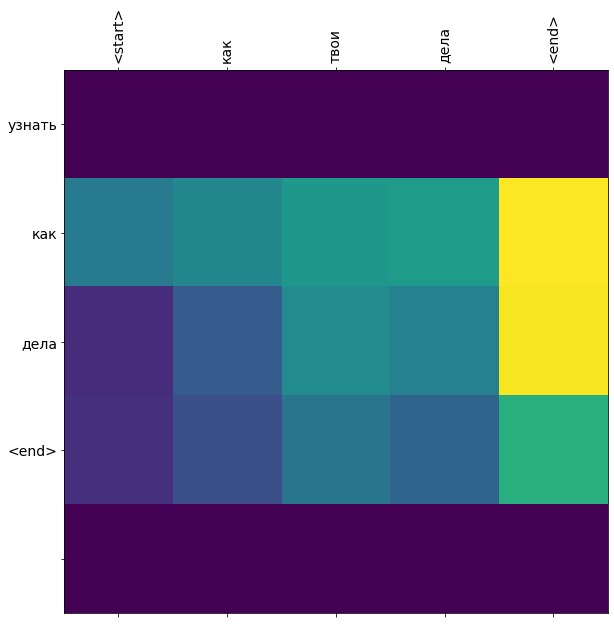

In [78]:
# This shows which parts of the input sentence has the model's attention while translating:
translate('как твои дела')

Input: <start> какая погода <end>
Predicted translation: узнать метеопрогноз на сегодня <end> 


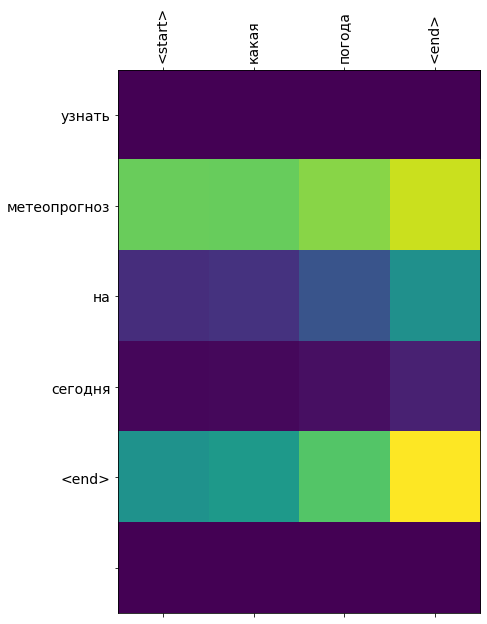

In [77]:
translate('какая погода')

Input: <start> когда будет следующии урок <end>
Predicted translation: узнать расписание занятии <end> 


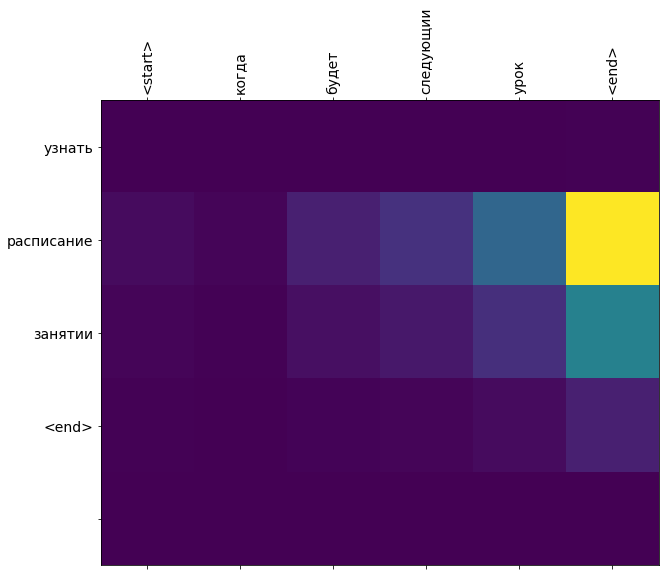

In [81]:
translate('когда будет следующий урок')

Input: <start> разослать информацию в слаке <end>
Predicted translation: сделать уведомление студентам канала <end> 


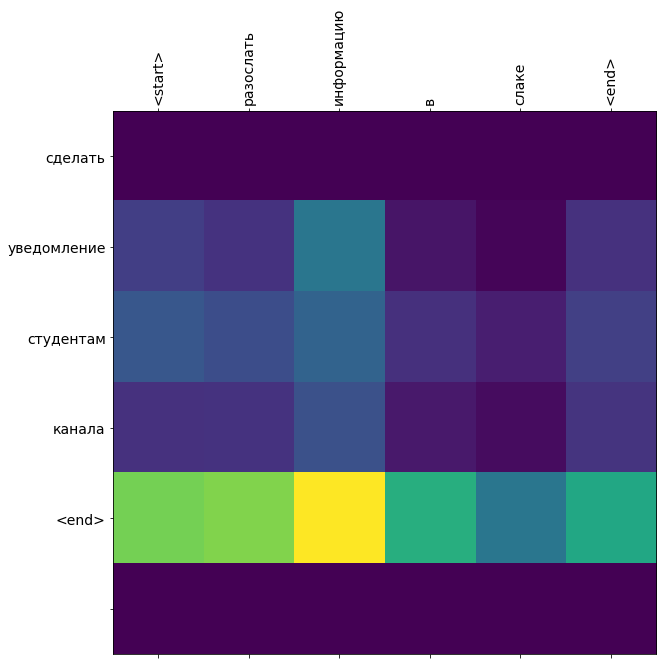

In [82]:
translate('разослать информацию в слаке')

In [128]:
# проверим качество, пропустив все предложения через скрипт
text = []
with open('F:/ОБУЧЕНИЕ/CHAT-BOTs/тексты/dialogues/_phrases3.txt', encoding='utf-8') as f:
    text.append(f.readlines())
correct_replies = []
with open('F:/ОБУЧЕНИЕ/CHAT-BOTs/тексты/dialogues/_intents3.txt', encoding='utf-8') as f:
    correct_replies.append(f.readlines())    

responses = []    
for i in range(len(text[0])):
    responses.append(
        re.sub('<end>', '', translate_short(text[0][i])).strip(' ')==correct_replies[0][i].replace('\n', '')
    )

In [129]:
np.sum(responses)/len(responses)

0.8487282463186078